In [0]:
# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import itertools

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = '/content/drive/My Drive/UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
filename = f'/content/drive/My Drive/UCI_HAR_Dataset/train/y_train.txt'
y=pd.read_csv(filename, delim_whitespace=True, header=None)
y[y<=3] = 0
y[y>3] = 1
print(y)

      0
0     1
1     1
2     1
3     1
4     1
...  ..
7347  0
7348  0
7349  0
7350  0
7351  0

[7352 rows x 1 columns]


In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/content/drive/My Drive/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/content/drive/My Drive/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [3]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM,Bidirectional
from keras.layers.core import Dense, Dropout
from keras import regularizers
from keras.layers import Conv1D
from keras.layers import Input, Dense,TimeDistributed
from keras.models import Model


Using TensorFlow backend.


In [0]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 6

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()
np.save("/content/drive/My Drive/train", X_train)
np.save("/content/drive/My Drive/train_label", Y_train)
np.save("/content/drive/My Drive/test", X_test)
np.save("/content/drive/My Drive/test_label", Y_test)

In [0]:
def data():
    x_train = np.load("/content/drive/My Drive/train.npy")
    y_train = np.load("/content/drive/My Drive/train_label.npy")
    x_test = np.load("/content/drive/My Drive/test.npy")
    y_test = np.load("/content/drive/My Drive/test_label.npy")
    return x_train, y_train, x_test, y_test

In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [0]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform


# CNN1D LSTM  MODEL

In [0]:
def data():
  class scaling_tseries_data():
    def __init__(self):
      self.scale = None

    def transform(self, X):
      temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
      temp_X1 = self.scale.transform(temp_X1)
      return temp_X1.reshape(X.shape)

    def fit(self, X):
      remove = int(X.shape[1] / 2)
      temp_X = X[:, -remove:, :]
      # flatten data
      temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
      scale = StandardScaler()
      scale.fit(temp_X)
      self.scale = scale
      return self
  def _read_csv(filename):
      return pd.read_csv(filename, delim_whitespace=True, header=None)

  def load_y(subset):
    filename = f'/content/drive/My Drive/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).as_matrix()
  def load_signals(subset):
    signals_data = []

    for signal in [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"]:
      filename = f'/content/drive/My Drive/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
      signals_data.append(_read_csv(filename).as_matrix()) 
    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

  X_train_d,X_val_d=load_signals('train'),load_signals('test')
  Y_train_d,Y_val_d = load_y('train'), load_y('test')

  Scale = scaling_tseries_data()
  Scale.fit(X_train_d)
  X_train_d = Scale.transform(X_train_d)
  X_val_d = Scale.transform(X_val_d)
  n_timestamps,n_features=X_train_d.shape[1],X_train_d.shape[2]
  n_steps,n_length=4,32
  X_train_d=X_train_d.reshape((X_train_d.shape[0],n_steps,n_length,n_features))
  X_val_d=X_val_d.reshape((X_val_d.shape[0],n_steps,n_length,n_features))

  return X_train_d, Y_train_d, X_val_d, Y_val_d

In [0]:
X_train_d, Y_train_d, X_val_d,  Y_val_d = data()

In [8]:
print('Train X shape',X_train_d.shape,'Test X shape',X_val_d.shape)
print('Train True_Y shape',Y_train_d.shape,'Test True_Y shape',Y_val_d.shape)


Train X shape (7352, 4, 32, 9) Test X shape (2947, 4, 32, 9)
Train True_Y shape (7352, 6) Test True_Y shape (2947, 6)


In [0]:
from keras.layers import Conv1D,MaxPooling1D,Flatten,LSTM
import keras

In [0]:
#https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
def MODEL(X_train_d,Y_train_d,X_val_d,Y_val_d):

  model=Sequential()
  model.add(TimeDistributed(Conv1D(filters=72,kernel_size=4,activation='relu',kernel_regularizer=regularizers.l2({{uniform(0.000000001,0.000001)}})),input_shape=(None,32,9)))

  model.add(TimeDistributed(Conv1D(filters=32,kernel_size=3,activation='relu',kernel_regularizer=regularizers.l2({{uniform(0.0000000001,0.00001)}}))))
  model.add(TimeDistributed(Dropout({{uniform(0.2,1)}})))
  model.add(TimeDistributed(MaxPooling1D(pool_size={{choice([2,4,5,7,9,8,3,6])}})))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(170,kernel_regularizer=regularizers.l2({{uniform(0.000000001,0.000001)}})))
  model.add(Dropout({{uniform(0.6,1)}}))
  model.add(Dense(64,activation='relu',kernel_regularizer=regularizers.l2({{uniform(0.000000001,0.000001)}})))
  model.add(Dense(6,activation='softmax'))
  adam = keras.optimizers.Adam(lr={{uniform(0.00065,0.004)}})

  print(model.summary())
      
  model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=adam)
  
  result = model.fit(X_train_d, Y_train_d,
            batch_size=16,
            nb_epoch=40,
            verbose=2,
            validation_data=(X_val_d, Y_val_d))
                      
  score, acc = model.evaluate(X_val_d, Y_val_d, verbose=0)
  score1, acc1 = model.evaluate(X_train_d, Y_train_d, verbose=0)
  print('Train accuracy',acc1,'Test accuracy:', acc)
  print('-------------------------------------------------------------------------------------')
  
  return {'loss': -acc, 'status': STATUS_OK,'train_acc':acc1,'model':model}

In [26]:
best_run, best_model ,space= optim.minimize(model=MODEL, data=data, algo=tpe.suggest, max_evals=10, trials=Trials(), notebook_name = "/drive/My Drive/himanshukatarwar11@gmail.com_Assigment23",return_space=True)



>>> Imports:
#coding=utf-8

try:
    from google.colab import drive
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pickle
except:
    pass

try:
    from sklearn.preprocessing import StandardScaler
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import LSTM, Bidirectional
except:
    pass

try:
    from keras.layers.core import Dense, Dropout
except:
    pass

try:
    from keras import regularizers
except:
    pass

try:
    from keras.layers import Conv1D
except:
    pass

try:
    from keras.layers import Input, Dense, TimeDistributed
except:
    pass

try:
    from keras.models import Model
except:
    pass

try:
    from hyperopt import Trials, STATUS_OK, tpe
except:
    pass

try:
    from hyperas import optim
except:
    pass

try:
  

/usr/local/lib/python3.6/dist-packages/hyperas/utils.py:149: UserWarning: Inconsistent indentation detected.Found "  " (length: 2) as well as "    " (length: 4)
  indent, len(indent), new_indent, len(new_indent)))
/usr/local/lib/python3.6/dist-packages/hyperas/utils.py:149: UserWarning: Inconsistent indentation detected.Found "    " (length: 4) as well as "  " (length: 2)
  indent, len(indent), new_indent, len(new_indent)))
/content/temp_model.py:151: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  signals_data.append(_read_csv(filename).as_matrix())
/content/temp_model.py:136: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return pd.get_dummies(y).as_matrix()


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_132 (TimeDi (None, None, 29, 72)      2664      
_________________________________________________________________
time_distributed_133 (TimeDi (None, None, 27, 32)      6944      
_________________________________________________________________
time_distributed_134 (TimeDi (None, None, 27, 32)      0         
_________________________________________________________________
time_distributed_135 (TimeDi (None, None, 9, 32)       0         
_________________________________________________________________
time_distributed_136 (TimeDi (None, None, 288)         0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 170)               312120    
_________________________________________________________________
dropout_58 (Dropout)         (None, 170)             

/content/temp_model.py:195: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_d, Y_val_d))



Train on 7352 samples, validate on 2947 samples
Epoch 1/40
 - 24s - loss: 0.3696 - acc: 0.8460 - val_loss: 0.2979 - val_acc: 0.9019

Epoch 2/40
 - 14s - loss: 0.1357 - acc: 0.9482 - val_loss: 0.2157 - val_acc: 0.9182

Epoch 3/40
 - 15s - loss: 0.1197 - acc: 0.9490 - val_loss: 0.2262 - val_acc: 0.9243

Epoch 4/40
 - 15s - loss: 0.1182 - acc: 0.9514 - val_loss: 0.2322 - val_acc: 0.9196

Epoch 5/40
 - 16s - loss: 0.1125 - acc: 0.9529 - val_loss: 0.2304 - val_acc: 0.9253

Epoch 6/40
 - 15s - loss: 0.0897 - acc: 0.9596 - val_loss: 0.4063 - val_acc: 0.8897

Epoch 7/40
 - 15s - loss: 0.0946 - acc: 0.9577 - val_loss: 0.2651 - val_acc: 0.9335

Epoch 8/40
 - 15s - loss: 0.0833 - acc: 0.9623 - val_loss: 0.2821 - val_acc: 0.9270

Epoch 9/40
 - 15s - loss: 0.0914 - acc: 0.9611 - val_loss: 0.2692 - val_acc: 0.9060

Epoch 10/40
 - 15s - loss: 0.1017 - acc: 0.9572 - val_loss: 0.3370 - val_acc: 0.9264

Epoch 11/40
 - 15s - loss: 0.0868 - acc: 0.9653 - val_loss: 0.2436 - val_acc: 0.9247

Epoch 12/40
 - 

/content/temp_model.py:195: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_d, Y_val_d))



Train on 7352 samples, validate on 2947 samples
Epoch 1/40
 - 23s - loss: 0.4686 - acc: 0.8200 - val_loss: 0.1985 - val_acc: 0.9189

Epoch 2/40
 - 12s - loss: 0.1621 - acc: 0.9403 - val_loss: 0.2260 - val_acc: 0.9057

Epoch 3/40
 - 12s - loss: 0.1376 - acc: 0.9484 - val_loss: 0.2378 - val_acc: 0.9175

Epoch 4/40
 - 12s - loss: 0.1192 - acc: 0.9524 - val_loss: 0.2359 - val_acc: 0.9237

Epoch 5/40
 - 12s - loss: 0.1343 - acc: 0.9493 - val_loss: 0.2326 - val_acc: 0.9291

Epoch 6/40
 - 12s - loss: 0.1259 - acc: 0.9529 - val_loss: 0.2979 - val_acc: 0.9223

Epoch 7/40
 - 12s - loss: 0.1125 - acc: 0.9577 - val_loss: 0.2459 - val_acc: 0.9230

Epoch 8/40
 - 12s - loss: 0.1016 - acc: 0.9585 - val_loss: 0.2100 - val_acc: 0.9257

Epoch 9/40
 - 12s - loss: 0.1062 - acc: 0.9585 - val_loss: 0.2947 - val_acc: 0.9352

Epoch 10/40
 - 12s - loss: 0.0888 - acc: 0.9664 - val_loss: 0.2905 - val_acc: 0.9294

Epoch 11/40
 - 12s - loss: 0.0915 - acc: 0.9634 - val_loss: 0.2837 - val_acc: 0.9321

Epoch 12/40
 - 

/content/temp_model.py:195: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_d, Y_val_d))



Train on 7352 samples, validate on 2947 samples
Epoch 1/40
 - 20s - loss: 0.9011 - acc: 0.6246 - val_loss: 0.4400 - val_acc: 0.7631

Epoch 2/40
 - 12s - loss: 0.6237 - acc: 0.7312 - val_loss: 0.6144 - val_acc: 0.7153

Epoch 3/40
 - 12s - loss: 0.5939 - acc: 0.7244 - val_loss: 0.4832 - val_acc: 0.7520

Epoch 4/40
 - 12s - loss: 0.5499 - acc: 0.7327 - val_loss: 0.4673 - val_acc: 0.7418

Epoch 5/40
 - 12s - loss: 0.4835 - acc: 0.7565 - val_loss: 0.4475 - val_acc: 0.7418

Epoch 6/40
 - 12s - loss: 0.5334 - acc: 0.7361 - val_loss: 0.4933 - val_acc: 0.7526

Epoch 7/40
 - 12s - loss: 0.5034 - acc: 0.7486 - val_loss: 0.4401 - val_acc: 0.7621

Epoch 8/40
 - 12s - loss: 0.4910 - acc: 0.7587 - val_loss: 0.5595 - val_acc: 0.7710

Epoch 9/40
 - 12s - loss: 0.5317 - acc: 0.7461 - val_loss: 0.4896 - val_acc: 0.7665

Epoch 10/40
 - 12s - loss: 0.5557 - acc: 0.7421 - val_loss: 0.4851 - val_acc: 0.7594

Epoch 11/40
 - 12s - loss: 0.4813 - acc: 0.7511 - val_loss: 0.4966 - val_acc: 0.7553

Epoch 12/40
 - 

/content/temp_model.py:195: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_d, Y_val_d))



Train on 7352 samples, validate on 2947 samples
Epoch 1/40
 - 22s - loss: 0.3549 - acc: 0.8580 - val_loss: 0.2547 - val_acc: 0.9050

Epoch 2/40
 - 13s - loss: 0.1932 - acc: 0.9283 - val_loss: 0.2296 - val_acc: 0.9155

Epoch 3/40
 - 12s - loss: 0.1479 - acc: 0.9404 - val_loss: 0.3933 - val_acc: 0.9063

Epoch 4/40
 - 12s - loss: 0.1468 - acc: 0.9404 - val_loss: 0.2393 - val_acc: 0.9284

Epoch 5/40
 - 12s - loss: 0.1491 - acc: 0.9426 - val_loss: 0.2597 - val_acc: 0.9087

Epoch 6/40
 - 11s - loss: 0.1274 - acc: 0.9449 - val_loss: 0.2597 - val_acc: 0.9165

Epoch 7/40
 - 11s - loss: 0.1531 - acc: 0.9400 - val_loss: 0.4924 - val_acc: 0.8673

Epoch 8/40
 - 12s - loss: 0.1380 - acc: 0.9388 - val_loss: 0.3308 - val_acc: 0.9203

Epoch 9/40
 - 12s - loss: 0.1294 - acc: 0.9453 - val_loss: 0.2917 - val_acc: 0.9080

Epoch 10/40
 - 12s - loss: 0.1184 - acc: 0.9504 - val_loss: 0.3128 - val_acc: 0.9121

Epoch 11/40
 - 12s - loss: 0.1191 - acc: 0.9487 - val_loss: 0.3358 - val_acc: 0.9175

Epoch 12/40
 - 

/content/temp_model.py:195: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_d, Y_val_d))



Train on 7352 samples, validate on 2947 samples
Epoch 1/40
 - 21s - loss: 0.9451 - acc: 0.5835 - val_loss: 0.7053 - val_acc: 0.5972

Epoch 2/40
 - 11s - loss: 0.5887 - acc: 0.7276 - val_loss: 0.4855 - val_acc: 0.7438

Epoch 3/40
 - 11s - loss: 0.6682 - acc: 0.7218 - val_loss: 0.5546 - val_acc: 0.7370

Epoch 4/40
 - 11s - loss: 0.5608 - acc: 0.7327 - val_loss: 0.5004 - val_acc: 0.7458

Epoch 5/40
 - 12s - loss: 0.5944 - acc: 0.7176 - val_loss: 0.5717 - val_acc: 0.7194

Epoch 6/40
 - 12s - loss: 0.5490 - acc: 0.7379 - val_loss: 0.4713 - val_acc: 0.7455

Epoch 7/40
 - 12s - loss: 0.5410 - acc: 0.7354 - val_loss: 0.4936 - val_acc: 0.7363

Epoch 8/40
 - 12s - loss: 0.5453 - acc: 0.7477 - val_loss: 0.4476 - val_acc: 0.7618

Epoch 9/40
 - 12s - loss: 0.5443 - acc: 0.7428 - val_loss: 0.4821 - val_acc: 0.7329

Epoch 10/40
 - 11s - loss: 0.5065 - acc: 0.7473 - val_loss: 0.4900 - val_acc: 0.7574

Epoch 11/40
 - 11s - loss: 0.5316 - acc: 0.7383 - val_loss: 0.4727 - val_acc: 0.7177

Epoch 12/40
 - 

/content/temp_model.py:195: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_d, Y_val_d))



Train on 7352 samples, validate on 2947 samples
Epoch 1/40
 - 22s - loss: 0.5000 - acc: 0.7934 - val_loss: 0.2935 - val_acc: 0.9026

Epoch 2/40
 - 12s - loss: 0.2180 - acc: 0.9166 - val_loss: 0.3167 - val_acc: 0.8968

Epoch 3/40
 - 12s - loss: 0.1742 - acc: 0.9324 - val_loss: 0.3287 - val_acc: 0.8778

Epoch 4/40
 - 12s - loss: 0.1507 - acc: 0.9397 - val_loss: 0.2940 - val_acc: 0.9077

Epoch 5/40
 - 12s - loss: 0.1535 - acc: 0.9354 - val_loss: 0.2733 - val_acc: 0.9145

Epoch 6/40
 - 12s - loss: 0.1522 - acc: 0.9410 - val_loss: 0.3087 - val_acc: 0.9070

Epoch 7/40
 - 12s - loss: 0.1393 - acc: 0.9423 - val_loss: 0.3181 - val_acc: 0.9074

Epoch 8/40
 - 12s - loss: 0.1287 - acc: 0.9482 - val_loss: 0.2818 - val_acc: 0.9080

Epoch 9/40
 - 12s - loss: 0.1378 - acc: 0.9464 - val_loss: 0.2930 - val_acc: 0.9165

Epoch 10/40
 - 12s - loss: 0.1367 - acc: 0.9464 - val_loss: 0.2727 - val_acc: 0.9220

Epoch 11/40
 - 12s - loss: 0.1273 - acc: 0.9493 - val_loss: 0.3332 - val_acc: 0.9155

Epoch 12/40
 - 

/content/temp_model.py:195: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_d, Y_val_d))



Train on 7352 samples, validate on 2947 samples
Epoch 1/40
 - 22s - loss: 1.3850 - acc: 0.4388 - val_loss: 0.9047 - val_acc: 0.5154

Epoch 2/40
 - 12s - loss: 1.1341 - acc: 0.4713 - val_loss: 0.8539 - val_acc: 0.5144

Epoch 3/40
 - 11s - loss: 1.0099 - acc: 0.4849 - val_loss: 0.8429 - val_acc: 0.5063

Epoch 4/40
 - 11s - loss: 1.0948 - acc: 0.4682 - val_loss: 0.8714 - val_acc: 0.5144

Epoch 5/40
 - 11s - loss: 1.0909 - acc: 0.4697 - val_loss: 0.8832 - val_acc: 0.5256

Epoch 6/40
 - 11s - loss: 1.1281 - acc: 0.4833 - val_loss: 1.1885 - val_acc: 0.5171

Epoch 9/40
 - 12s - loss: 1.0969 - acc: 0.4716 - val_loss: 1.8223 - val_acc: 0.3370

Epoch 10/40
 - 11s - loss: 1.0356 - acc: 0.4812 - val_loss: 0.9267 - val_acc: 0.5256

Epoch 11/40
 - 11s - loss: 1.0218 - acc: 0.4971 - val_loss: 1.1785 - val_acc: 0.4571

Epoch 12/40
 - 11s - loss: 1.0037 - acc: 0.4822 - val_loss: 0.9930 - val_acc: 0.5300

Epoch 13/40
 - 11s - loss: 1.0738 - acc: 0.4859 - val_loss: 0.9307 - val_acc: 0.5178

Epoch 14/40
 

/content/temp_model.py:195: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_d, Y_val_d))



Train on 7352 samples, validate on 2947 samples
Epoch 1/40
 - 24s - loss: 3.0198 - acc: 0.2043 - val_loss: 2.0500 - val_acc: 0.0573

Epoch 2/40
 - 12s - loss: 2.6333 - acc: 0.2278 - val_loss: 2.1834 - val_acc: 0.3339

Epoch 3/40
 - 12s - loss: 2.5356 - acc: 0.2227 - val_loss: 2.4656 - val_acc: 0.2294

Epoch 4/40
 - 12s - loss: 2.4777 - acc: 0.2274 - val_loss: 2.5650 - val_acc: 0.1805

Epoch 5/40
 - 13s - loss: 2.6536 - acc: 0.2044 - val_loss: 2.5114 - val_acc: 0.2277

Epoch 6/40
 - 12s - loss: 2.7222 - acc: 0.2033 - val_loss: 2.7133 - val_acc: 0.2396

Epoch 7/40
 - 12s - loss: 2.5771 - acc: 0.1872 - val_loss: 2.4246 - val_acc: 0.2348

Epoch 8/40
 - 13s - loss: 2.6127 - acc: 0.1961 - val_loss: 2.6498 - val_acc: 0.1666

Epoch 9/40
 - 13s - loss: 2.5766 - acc: 0.1897 - val_loss: 2.8889 - val_acc: 0.1666

Epoch 10/40
 - 12s - loss: 2.5613 - acc: 0.1907 - val_loss: 3.2998 - val_acc: 0.1666

Epoch 11/40
 - 12s - loss: 2.5616 - acc: 0.1829 - val_loss: 3.5252 - val_acc: 0.1666

Epoch 12/40
 - 

/content/temp_model.py:195: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_d, Y_val_d))



Train on 7352 samples, validate on 2947 samples
Epoch 1/40
 - 25s - loss: 0.8380 - acc: 0.6459 - val_loss: 0.5221 - val_acc: 0.8364

Epoch 2/40
 - 12s - loss: 0.3874 - acc: 0.8347 - val_loss: 0.3148 - val_acc: 0.8921

Epoch 3/40
 - 12s - loss: 0.2640 - acc: 0.9116 - val_loss: 0.2536 - val_acc: 0.8918

Epoch 4/40
 - 12s - loss: 0.1987 - acc: 0.9255 - val_loss: 0.2415 - val_acc: 0.9247

Epoch 5/40
 - 12s - loss: 0.2030 - acc: 0.9316 - val_loss: 0.2235 - val_acc: 0.9155

Epoch 6/40
 - 12s - loss: 0.1845 - acc: 0.9287 - val_loss: 0.2785 - val_acc: 0.9131

Epoch 7/40
 - 12s - loss: 0.1765 - acc: 0.9344 - val_loss: 0.2570 - val_acc: 0.9145

Epoch 8/40
 - 12s - loss: 0.1875 - acc: 0.9304 - val_loss: 0.2710 - val_acc: 0.9209

Epoch 9/40
 - 12s - loss: 0.1741 - acc: 0.9368 - val_loss: 0.2988 - val_acc: 0.9220

Epoch 10/40
 - 12s - loss: 0.1601 - acc: 0.9418 - val_loss: 0.3128 - val_acc: 0.9220

Epoch 11/40
 - 12s - loss: 0.1519 - acc: 0.9408 - val_loss: 0.2472 - val_acc: 0.9332

Epoch 12/40
 - 

/content/temp_model.py:195: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_d, Y_val_d))



Train on 7352 samples, validate on 2947 samples
Epoch 1/40
 - 25s - loss: 0.9293 - acc: 0.5928 - val_loss: 1.1917 - val_acc: 0.5066

Epoch 2/40
 - 12s - loss: 0.6507 - acc: 0.6907 - val_loss: 1.0210 - val_acc: 0.5684

Epoch 3/40
 - 12s - loss: 0.5480 - acc: 0.7597 - val_loss: 0.6519 - val_acc: 0.6698

Epoch 4/40
 - 12s - loss: 0.4667 - acc: 0.7983 - val_loss: 0.6853 - val_acc: 0.6678

Epoch 5/40
 - 12s - loss: 0.4407 - acc: 0.8162 - val_loss: 0.5511 - val_acc: 0.7323

Epoch 6/40
 - 12s - loss: 0.4006 - acc: 0.8445 - val_loss: 0.5048 - val_acc: 0.7693

Epoch 7/40
 - 11s - loss: 0.3538 - acc: 0.8663 - val_loss: 0.4734 - val_acc: 0.7917

Epoch 8/40
 - 12s - loss: 0.3524 - acc: 0.8692 - val_loss: 0.4330 - val_acc: 0.8347

Epoch 9/40
 - 12s - loss: 0.3133 - acc: 0.8822 - val_loss: 0.3870 - val_acc: 0.8616

Epoch 10/40
 - 12s - loss: 0.2874 - acc: 0.8962 - val_loss: 0.4210 - val_acc: 0.8578

Epoch 11/40
 - 12s - loss: 0.2794 - acc: 0.8993 - val_loss: 0.3585 - val_acc: 0.8568

Epoch 12/40
 - 

In [28]:
X_train_d, Y_train_d, X_val_d,  Y_val_d = data()
score = best_model.evaluate(X_val_d, Y_val_d)

print('---------------------')
print('|      Accuracy      |')
print('---------------------')
acc = np.round((score[1]*100), 2)
print(str(acc)+"%\n")
    
print('----------------------------------')
print('|      Best Hyper-Parameters      |')
print('----------------------------------')
print(best_run)
print("\n\n")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


2947/2947 [==============================] - 1s 284us/step
---------------------
|      Accuracy      |
---------------------
94.37%

----------------------------------
|      Best Hyper-Parameters      |
----------------------------------
{'Dropout': 0.3257301479402539, 'Dropout_1': 0.8176968367924008, 'l2': 4.3460722016022965e-07, 'l2_1': 6.975105778097833e-06, 'l2_2': 5.157655840964875e-07, 'l2_3': 4.2580338825158776e-07, 'lr': 0.0014310905039904911, 'pool_size': 4}





In [0]:
import matplotlib.pyplot as plt
#https://github.com/UdiBhaskar/Human-Activity-Recognition--Using-Deep-NN
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=90)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

def confusion_matrix_cnn(Y_true, Y_pred):
  Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
  Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
  #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
  return metrics.confusion_matrix(Y_true, Y_pred)

---------------------
|      Accuracy      |
---------------------
94.37%



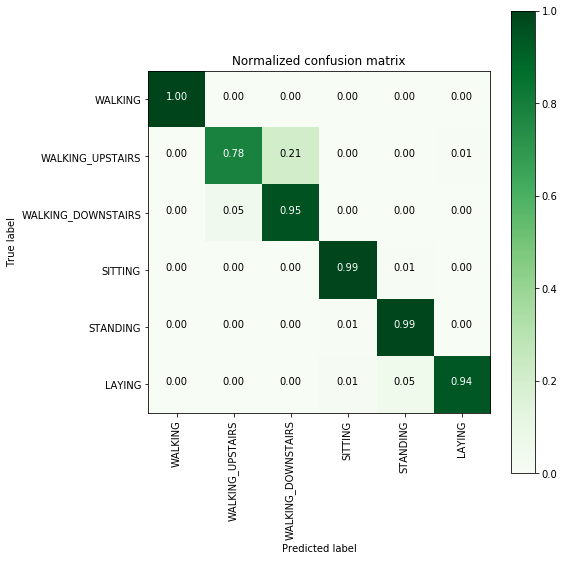

In [44]:
print('---------------------')
print('|      Accuracy      |')
print('---------------------')
acc = np.round((score[1]*100), 2)
print(str(acc)+"%\n")
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(Y_val_d, best_model.predict(X_val_d))
plot_confusion_matrix(cm, classes=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()